# Behavior Analysis: Binned-Ratio Timeline 

Press SHIFT + ENTER to run code

### USER INPUT!

In [1]:
## Define project
project_name = ''

# Select group and condition, see meta.py to see how you previously defined it for your project
selected_groups = ['', '']
selected_conditions = ['', '']

# KEEP SAME TO LOOK AT BEHAVIOR IN 1-MIN BINS!
num_min = 1

### Main Code: Created Binned-Ratio Timeline + CSVs

Data saved to ../processed_dataset/bla_sni_opto_inhibit/figures/behavior_binned-ratio-timeline/behavior_binned-ratio-timeline__bla_sni_opto_inhibit_SNI-CTRL_FLEX.csv.
Data saved to ../processed_dataset/bla_sni_opto_inhibit/figures/behavior_binned-ratio-timeline/behavior_binned-ratio-timeline__bla_sni_opto_inhibit_SNI-EXP_stGtACR2_inhibit.csv.


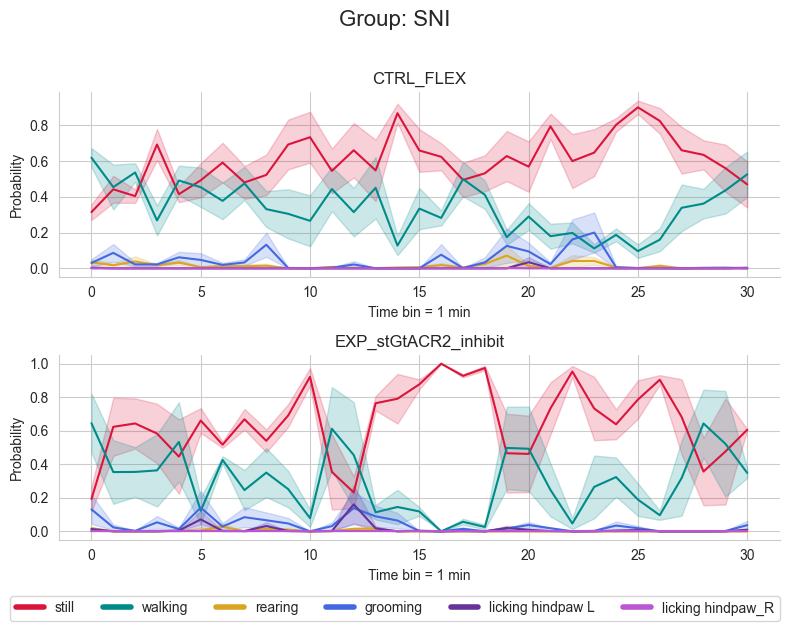

Data saved to ../processed_dataset/bla_sni_opto_inhibit/figures/behavior_binned-ratio-timeline/behavior_binned-ratio-timeline__bla_sni_opto_inhibit_NoSNI-CTRL_FLEX.csv.
Data saved to ../processed_dataset/bla_sni_opto_inhibit/figures/behavior_binned-ratio-timeline/behavior_binned-ratio-timeline__bla_sni_opto_inhibit_NoSNI-EXP_stGtACR2_inhibit.csv.


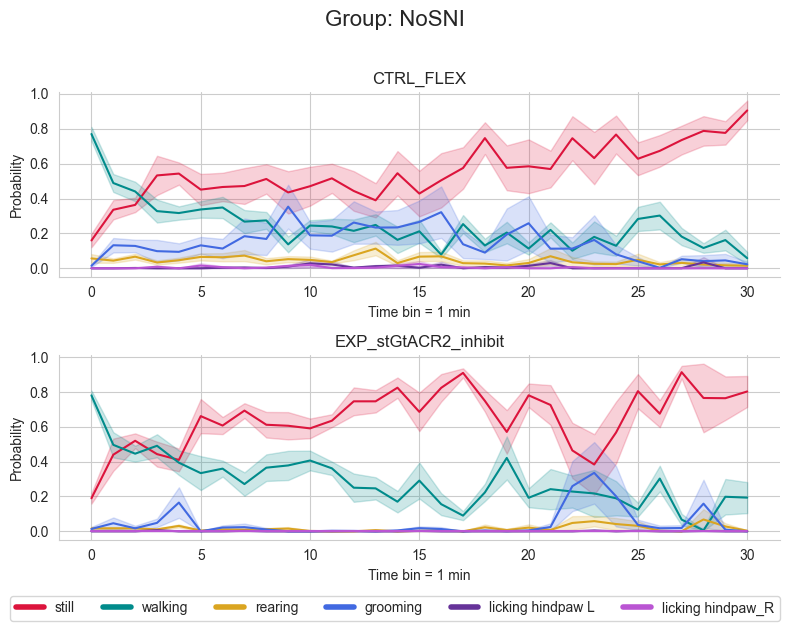

In [14]:
###### RUN DEPENDENCIES ######
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *

###### Load Behaviors ######
behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

# Parameters
time_bin_size = 60 * 60 * num_min

# Define the directory path
directory_path = f"../processed_dataset/{project_name}/figures/behavior_binned-ratio-timeline"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Check if behaviors is None or empty
if behaviors is None or not behaviors:
    print("Error: Failed to load behaviors or empty dataset.")
else:
    behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw_R']
    behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']

    for selected_group in selected_groups:
        fig, axes = plt.subplots(nrows=len(selected_conditions), figsize=(8, 2.5 * len(selected_conditions) + 1))
        fig.suptitle(f'Group: {selected_group}', fontsize=16)

        for idx, selected_condition in enumerate(selected_conditions):
            ax = axes[idx] if len(selected_conditions) > 1 else axes  # Handle single subplot case

            if selected_group in behaviors and selected_condition in behaviors[selected_group]:
                n_bins = len(behaviors[selected_group][selected_condition]['file0']) // time_bin_size

                behavior_ratios_files = {key: np.nan for key in range(len(behaviors[selected_group][selected_condition]))}

                for f in range(len(behaviors[selected_group][selected_condition])):
                    binned_behaviors = []
                    for bin_n in range(int(n_bins)):
                        behavior_ratios = {key: 0 for key in range(len(behavior_names))}
                        values, counts = np.unique(behaviors[selected_group][selected_condition][f'file{f}'][time_bin_size * bin_n:time_bin_size * (bin_n + 1)], return_counts=True)
                        for i, value in enumerate(values):
                            behavior_ratios[value] = counts[i] / sum(counts)
                        binned_behaviors.append(behavior_ratios)
                    behavior_ratios_files[f] = binned_behaviors

                data_to_save = {'Time_bin': np.arange(int(n_bins))}

                for b in range(len(behavior_names)):
                    y_files = []
                    for f in range(len(behavior_ratios_files)):
                        y_files.append(np.hstack([behavior_ratios_files[f][bin][b] for bin in range(len(behavior_ratios_files[f]))]))
                    y = np.mean(y_files, axis=0)
                    x = np.arange(int(n_bins))
                    y_sem = np.std(y_files, axis=0) / np.sqrt(len(behavior_ratios_files))

                    ax.plot(x, y, color=behavior_colors[b], label=behavior_names[b])
                    ax.fill_between(x, y - y_sem, y + y_sem, color=behavior_colors[b], alpha=0.2)

                    data_to_save[behavior_names[b]] = y
                    data_to_save[f'{behavior_names[b]}_SEM'] = y_sem

                ax.set_title(f'{selected_condition}')
                ax.set_xlabel(f'Time bin = {num_min} min')
                ax.set_ylabel('Probability')
                ax.spines[['top', 'right']].set_visible(False)
                df = pd.DataFrame(data_to_save)
                
                ## Define the output filename
                output_filename = f"../processed_dataset/{project_name}/figures/behavior_binned-ratio-timeline/behavior_binned-ratio-timeline__{project_name}_{selected_group}-{selected_condition}.csv"
                ## Save DataFrame to CSV
                df.to_csv(output_filename, index=False)
                print(f"Data saved to {output_filename}.")

            else:
                print(f"Error: Selected group '{selected_group}' or condition '{selected_condition}' not found in the dataset.")

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title

        # Create a single legend below all subplots
        handles, labels = [], []
        for color, name in zip(behavior_colors, behavior_names):
            handles.append(plt.Line2D([0], [0], color=color, lw=4))
            labels.append(name)
        
        fig.legend(handles, labels, loc='lower center', ncol=len(behavior_names), bbox_to_anchor=(0.5, -0.05))
        
        ## Save the figure
        save_path = f"../processed_dataset/{project_name}/figures/behavior_binned-ratio-timeline/behavior_binned-ratio-timeline_{project_name}_{selected_group}.svg"
        plt.savefig(save_path, format='svg', bbox_inches='tight')

        plt.show()

# ANALYSIS COMPLETE!